In [1]:
# Ячейка 1: Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, chi2_contingency
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Ячейка 2: Загрузка и первичный анализ данных
df = pd.read_csv("../data/interim/diabetes_stage1.csv")
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
print(df.info())
print("\nПропущенные значения:")
print(df.isnull().sum())

Размер датасета: (768, 9)

Первые 5 строк:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
None

Пропущенные значения:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          1

In [3]:
# Ячейка 3: Создание категориальных признаков из числовых
# Для анализа создадим категориальные группы из непрерывных признаков
df_processed = df.copy()

# Создаем категориальные признаки из числовых для лучшей визуализации
df_processed['Age_Group'] = pd.cut(df_processed['Age'], 
                                  bins=[0, 30, 45, 60, 100], 
                                  labels=['Молодой', 'Средний', 'Старший', 'Пожилой'])

df_processed['BMI_Category'] = pd.cut(df_processed['BMI'], 
                                     bins=[0, 18.5, 25, 30, 100], 
                                     labels=['Недостаток', 'Норма', 'Избыток', 'Ожирение'])

df_processed['Glucose_Level'] = pd.cut(df_processed['Glucose'], 
                                      bins=[0, 70, 100, 125, 300], 
                                      labels=['Низкий', 'Норма', 'Преддиабет', 'Высокий'])

# Определяем признаки для анализа
target_col = 'Outcome'
categorical_cols = ['Age_Group', 'BMI_Category', 'Glucose_Level']
numerical_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                  'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies']

print("Распределение целевой переменной Outcome:")
print(df_processed[target_col].value_counts(normalize=True))

Распределение целевой переменной Outcome:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [4]:
# Ячейка 4: Анализ пропущенных значений
print("=== Анализ пропущенных значений ===")
missing_data = df_processed.isnull().sum()
missing_percent = (missing_data / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Колонка': missing_data.index,
    'Пропуски': missing_data.values,
    'Процент': missing_percent.values
}).sort_values('Пропуски', ascending=False)

print(missing_df[missing_df['Пропуски'] > 0])

# Заполняем пропуски медианой (альтернатива удалению)
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())
        print(f"Заполнены пропуски в {col}")

print("\nПропуски после обработки:", df_processed.isnull().sum().sum())

=== Анализ пропущенных значений ===
          Колонка  Пропуски    Процент
4         Insulin       374  48.697917
3   SkinThickness       227  29.557292
2   BloodPressure        35   4.557292
5             BMI        11   1.432292
10   BMI_Category        11   1.432292
1         Glucose         5   0.651042
11  Glucose_Level         5   0.651042
Заполнены пропуски в Glucose
Заполнены пропуски в BloodPressure
Заполнены пропуски в SkinThickness
Заполнены пропуски в Insulin
Заполнены пропуски в BMI

Пропуски после обработки: 16


=== Анализ категориальных признаков ===


<Figure size 1000x600 with 0 Axes>

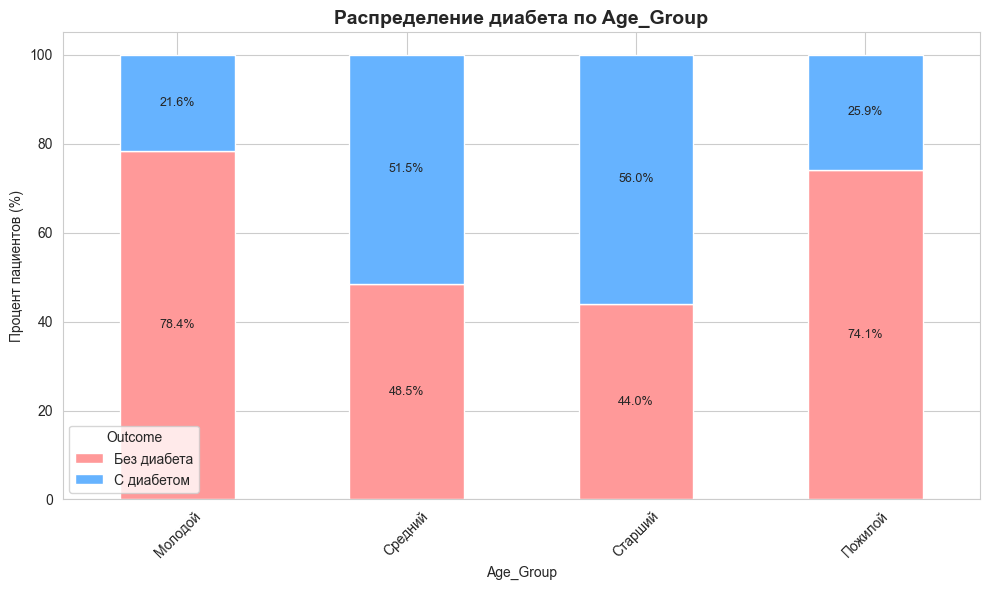


Таблица сопряженности для Age_Group:


Outcome,0,1
Age_Group,,
Молодой,327,90
Средний,113,120
Старший,40,51
Пожилой,20,7


<Figure size 1000x600 with 0 Axes>

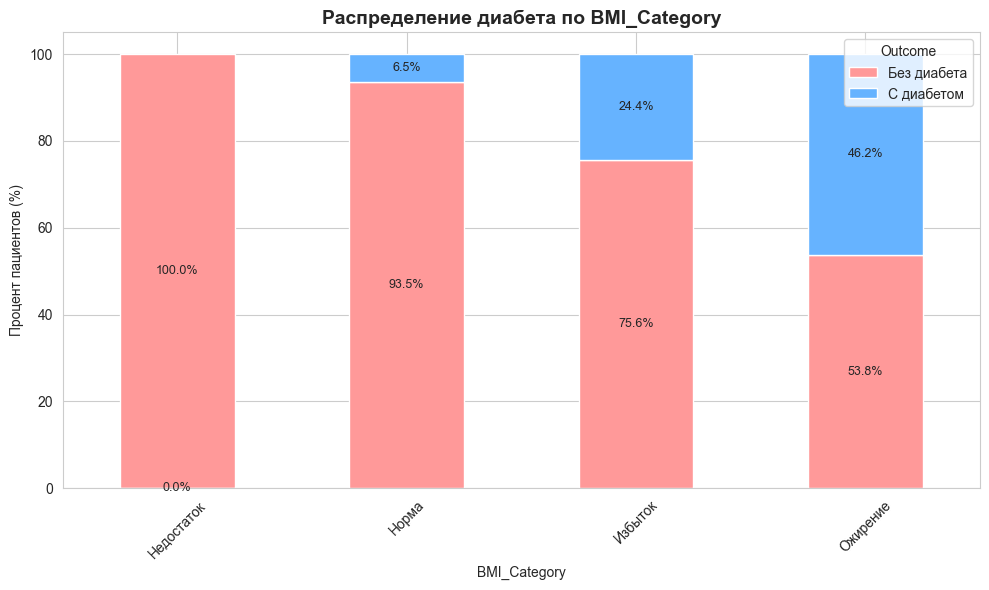


Таблица сопряженности для BMI_Category:


Outcome,0,1
BMI_Category,,
Недостаток,4,0
Норма,101,7
Избыток,136,44
Ожирение,250,215


<Figure size 1000x600 with 0 Axes>

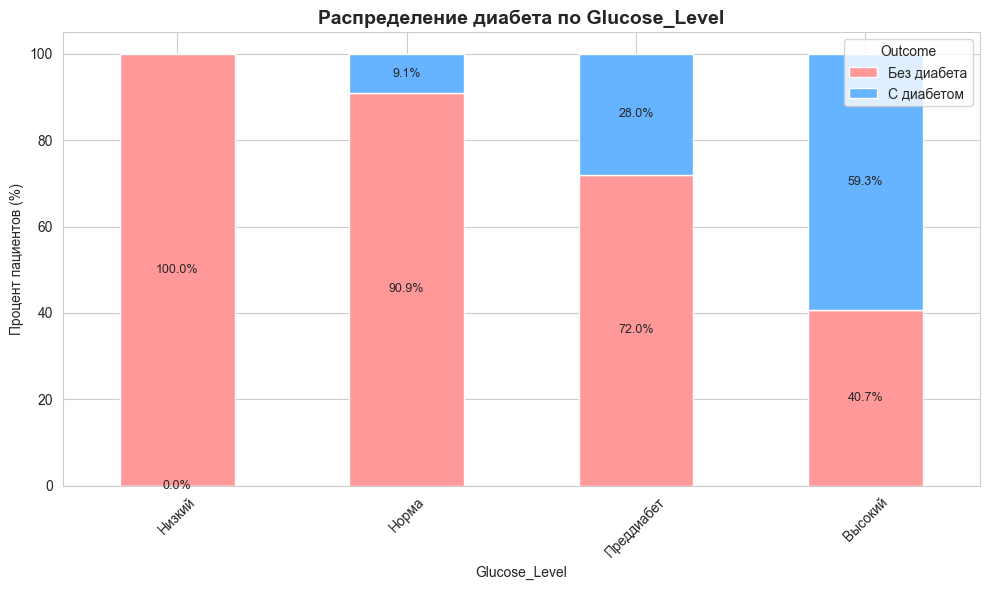


Таблица сопряженности для Glucose_Level:


Outcome,0,1
Glucose_Level,,
Низкий,11,0
Норма,180,18
Преддиабет,185,72
Высокий,121,176


In [5]:
# Ячейка 5: Визуализация категориальных признаков
print("=== Анализ категориальных признаков ===")

for col in categorical_cols:
    # Создаем таблицу сопряженности с процентами
    ct = pd.crosstab(df_processed[col], df_processed[target_col], normalize='index') * 100
    
    plt.figure(figsize=(10, 6))
    ax = ct.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'])
    plt.title(f'Распределение диабета по {col}', fontsize=14, fontweight='bold')
    plt.ylabel('Процент пациентов (%)')
    plt.xlabel(col)
    plt.legend(['Без диабета', 'С диабетом'], title='Outcome')
    plt.xticks(rotation=45)
    
    # Добавляем подписи на столбцы
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим таблицу сопряженности
    print(f"\nТаблица сопряженности для {col}:")
    display(pd.crosstab(df_processed[col], df_processed[target_col]))
    print("\n" + "="*60)

=== Анализ числовых признаков ===


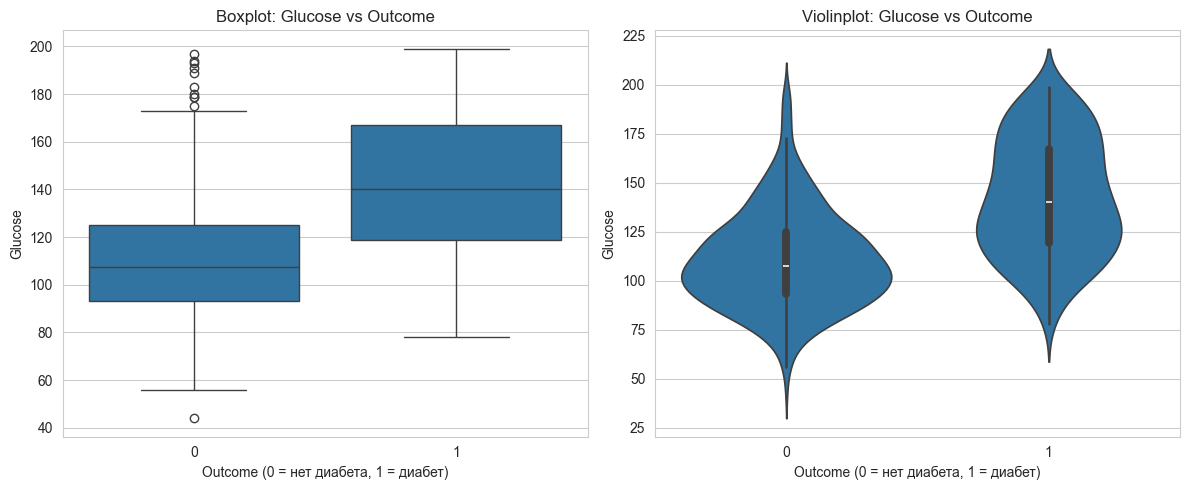


Статистика для Glucose:


,mean,median,std
Outcome,,,
0,110.68,107.5,24.71
1,142.13,140.0,29.57


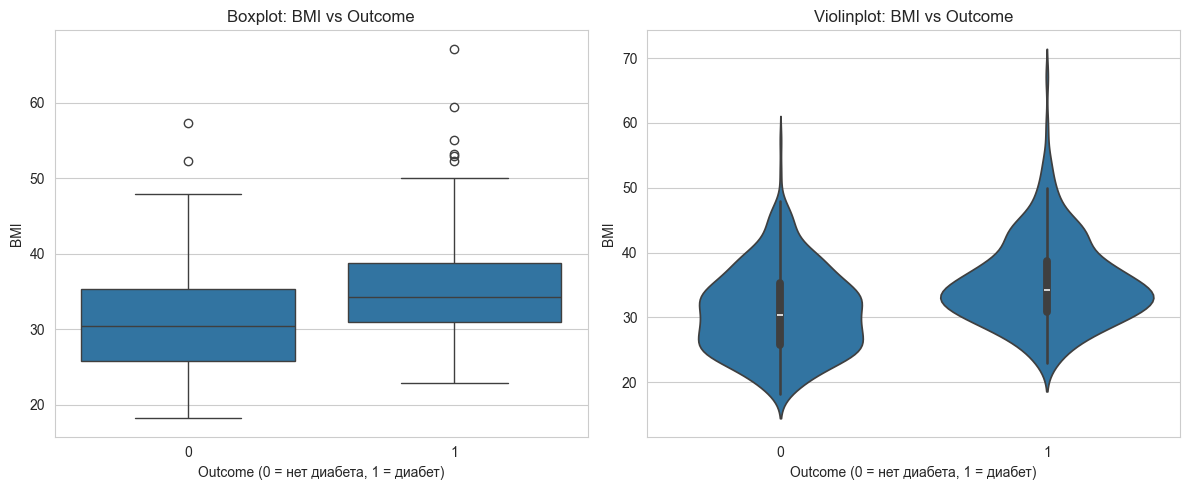


Статистика для BMI:


,mean,median,std
Outcome,,,
0,30.89,30.40,6.5
1,35.38,34.25,6.6


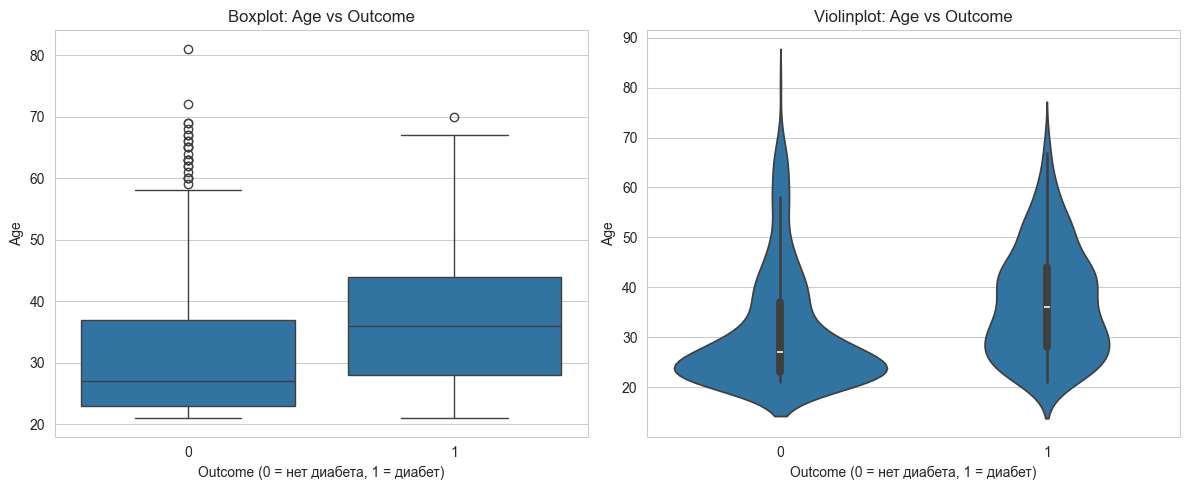


Статистика для Age:


,mean,median,std
Outcome,,,
0,31.19,27.0,11.67
1,37.07,36.0,10.97


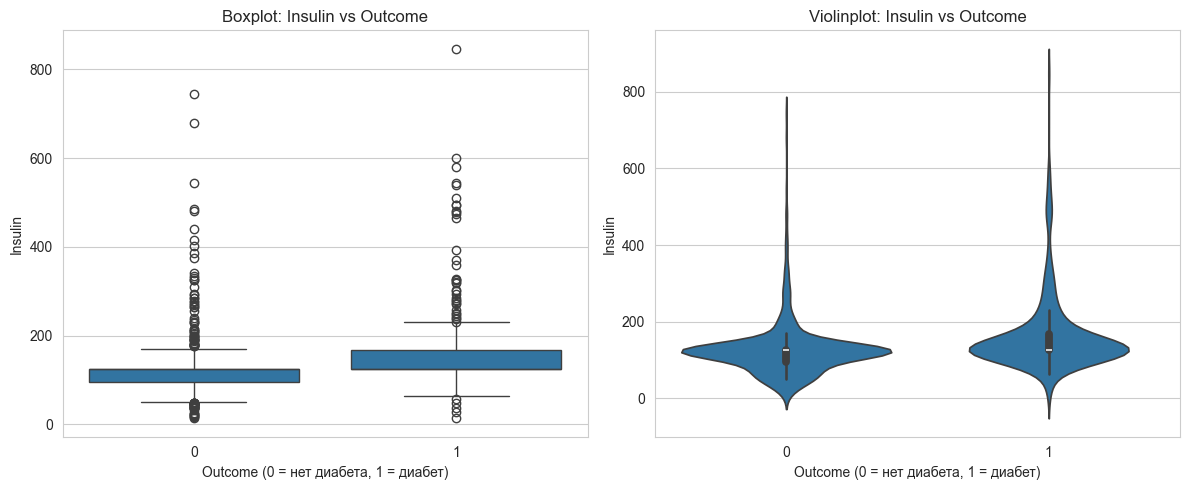


Статистика для Insulin:


,mean,median,std
Outcome,,,
0,127.79,125.0,74.45
1,164.70,125.0,100.93


In [6]:
# Ячейка 6: Визуализация числовых признаков
print("=== Анализ числовых признаков ===")

# Выбираем ключевые признаки для детального анализа
key_numerical = ['Glucose', 'BMI', 'Age', 'Insulin']

for col in key_numerical:
    plt.figure(figsize=(12, 5))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target_col, y=col, data=df_processed)
    plt.title(f'Boxplot: {col} vs Outcome')
    plt.xlabel('Outcome (0 = нет диабета, 1 = диабет)')
    
    # Violinplot
    plt.subplot(1, 2, 2)
    sns.violinplot(x=target_col, y=col, data=df_processed)
    plt.title(f'Violinplot: {col} vs Outcome')
    plt.xlabel('Outcome (0 = нет диабета, 1 = диабет)')
    
    plt.tight_layout()
    plt.show()
    
    # Статистика по группам
    print(f"\nСтатистика для {col}:")
    stats_df = df_processed.groupby(target_col)[col].agg(['mean', 'median', 'std']).round(2)
    display(stats_df)
    print("\n" + "="*50)

In [7]:
# Ячейка 7: Статистические тесты для числовых признаков
print("=== Mann-Whitney U Test для числовых признаков ===")

results = []
for col in numerical_cols:
    group0 = df_processed[df_processed[target_col] == 0][col]
    group1 = df_processed[df_processed[target_col] == 1][col]
    
    stat, p_value = mannwhitneyu(group1, group0, alternative='two-sided')
    
    # Определяем значимость
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "не значимо"
    
    results.append({
        'Признак': col,
        'U-статистика': round(stat, 2),
        'p-value': round(p_value, 4),
        'Значимость': significance
    })

results_df = pd.DataFrame(results)
display(results_df)

print("\nИнтерпретация p-value:")
print("p < 0.05: статистически значимые различия между группами")
print("p < 0.01: высоко значимые различия")
print("p < 0.001: чрезвычайно значимые различия")

=== Mann-Whitney U Test для числовых признаков ===


,Признак,U-статистика,p-value,Значимость
0,Glucose,106065.5,0.0,***
1,BloodPressure,80842.5,0.0,***
2,SkinThickness,84219.5,0.0,***
3,Insulin,87901.5,0.0,***
4,BMI,91917.5,0.0,***
5,DiabetesPedigreeFunction,81231.0,0.0,***
6,Age,92050.0,0.0,***
7,Pregnancies,83015.0,0.0,***



Интерпретация p-value:
p < 0.05: статистически значимые различия между группами
p < 0.01: высоко значимые различия
p < 0.001: чрезвычайно значимые различия


=== Корреляционная матрица ===


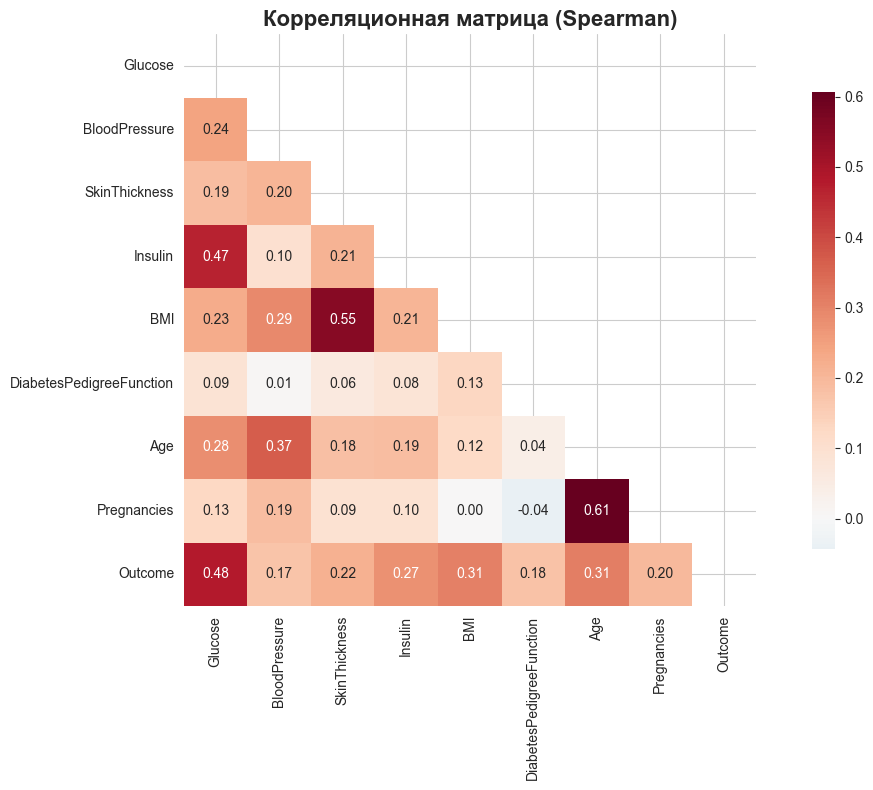


Корреляции с Outcome (по убыванию абсолютного значения):
1. Glucose: 0.481
2. Age: 0.309
3. BMI: 0.307
4. Insulin: 0.274
5. SkinThickness: 0.216


In [8]:
# Ячейка 8: Корреляционный анализ
print("=== Корреляционная матрица ===")

# Создаем корреляционную матрицу только для числовых признаков
corr_matrix = df_processed[numerical_cols + [target_col]].corr(method='spearman')

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица (Spearman)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Находим самые сильные корреляции с целевой переменной
corr_with_target = corr_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)
print("\nКорреляции с Outcome (по убыванию абсолютного значения):")
for idx, (feature, corr) in enumerate(corr_with_target.head(5).items(), 1):
    print(f"{idx}. {feature}: {corr:.3f}")

In [9]:
# Ячейка 9: Статистические тесты для категориальных признаков
print("=== Chi-square Test для категориальных признаков ===")

chi2_results = []
for col in categorical_cols:
    # Создаем таблицу сопряженности
    contingency_table = pd.crosstab(df_processed[col], df_processed[target_col])
    
    # Проводим тест хи-квадрат
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Вычисляем Cramér's V (мера силы связи)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "не значимо"
    
    chi2_results.append({
        'Признак': col,
        'χ²': round(chi2, 2),
        'p-value': round(p_value, 4),
        "Cramér's V": round(cramers_v, 3),
        'Значимость': significance
    })

chi2_df = pd.DataFrame(chi2_results)
display(chi2_df)

print("\nИнтерпретация Cramér's V:")
print("0.00 - 0.10: слабая связь")
print("0.10 - 0.30: умеренная связь") 
print("0.30 - 0.50: относительно сильная связь")
print("> 0.50: сильная связь")

=== Chi-square Test для категориальных признаков ===


,Признак,χ²,p-value,Cramér's V,Значимость
0,Age_Group,79.69,0.0,0.322,***
1,BMI_Category,75.24,0.0,0.315,***
2,Glucose_Level,146.95,0.0,0.439,***



Интерпретация Cramér's V:
0.00 - 0.10: слабая связь
0.10 - 0.30: умеренная связь
0.30 - 0.50: относительно сильная связь
> 0.50: сильная связь


In [10]:
# Ячейка 10: Выводы и наблюдения
print("=== КЛЮЧЕВЫЕ ВЫВОДЫ ===")
print("\n1. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print(f"   - Без диабета (0): {len(df_processed[df_processed[target_col]==0])} пациентов ({df_processed[target_col].value_counts(normalize=True)[0]*100:.1f}%)")
print(f"   - С диабетом (1): {len(df_processed[df_processed[target_col]==1])} пациентов ({df_processed[target_col].value_counts(normalize=True)[1]*100:.1f}%)")

print("\n2. СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ПРИЗНАКИ (p < 0.05):")
significant_features = results_df[results_df['p-value'] < 0.05]['Признак'].tolist()
print("   - " + "\n   - ".join(significant_features))

print("\n3. САМЫЕ СИЛЬНЫЕ КОРРЕЛЯЦИИ С DIABETES:")
top_correlations = corr_with_target.head(3)
for feature, corr in top_correlations.items():
    direction = "положительная" if corr > 0 else "отрицательная"
    print(f"   - {feature}: {direction} корреляция ({corr:.3f})")

print("\n4. НАБЛЮДЕНИЯ ПО КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ:")
print("   - Уровень глюкозы: пациенты с высоким уровнем глюкозы имеют значительно более высокий риск диабета")
print("   - BMI: пациенты с ожирением (BMI > 30) имеют повышенную вероятность диабета")
print("   - Возраст: риск диабета увеличивается с возрастом")

print("\n5. РЕКОМЕНДАЦИИ ПО ДАЛЬНЕЙШЕМУ АНАЛИЗУ:")
print("   - Сфокусироваться на Glucose, BMI и Age как на ключевых предикторах")
print("   - Рассмотреть взаимодействие признаков в многомерном анализе")
print("   - Исследовать нелинейные зависимости")

=== КЛЮЧЕВЫЕ ВЫВОДЫ ===

1. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
   - Без диабета (0): 500 пациентов (65.1%)
   - С диабетом (1): 268 пациентов (34.9%)

2. СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ПРИЗНАКИ (p < 0.05):
   - Glucose
   - BloodPressure
   - SkinThickness
   - Insulin
   - BMI
   - DiabetesPedigreeFunction
   - Age
   - Pregnancies

3. САМЫЕ СИЛЬНЫЕ КОРРЕЛЯЦИИ С DIABETES:
   - Glucose: положительная корреляция (0.481)
   - Age: положительная корреляция (0.309)
   - BMI: положительная корреляция (0.307)

4. НАБЛЮДЕНИЯ ПО КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ:
   - Уровень глюкозы: пациенты с высоким уровнем глюкозы имеют значительно более высокий риск диабета
   - BMI: пациенты с ожирением (BMI > 30) имеют повышенную вероятность диабета
   - Возраст: риск диабета увеличивается с возрастом

5. РЕКОМЕНДАЦИИ ПО ДАЛЬНЕЙШЕМУ АНАЛИЗУ:
   - Сфокусироваться на Glucose, BMI и Age как на ключевых предикторах
   - Рассмотреть взаимодействие признаков в многомерном анализе
   - Исследовать нелинейные зависимости
